# Preprocessing data

Tahap pertama penyetinggan API, Libraries, Dataset

melihat isi folder

install TensorFlow

In [2]:
import tensorflow as tf
print(tf.__version__)


2.9.1


In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


### Memastikan TensorFlow menggunakan GPU NVIDIA RTX 2070


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Pembagian data untuk train, validation dan test

### Aktivasi Mixed Precision

In [6]:
from tensorflow.keras import mixed_precision

# Mengatur kebijakan mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"Mixed precision policy set to: {mixed_precision.global_policy()}")


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070, compute capability 7.5
Mixed precision policy set to: <Policy "mixed_float16">


In [9]:
# Import library yang diperlukan
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Fungsi untuk memvalidasi dan membagi data menjadi train, valid, dan test
def split_data(data_dir, csv_dir):
    # Membaca file CSV ke dalam dataframe pandas
    df = pd.read_csv(csv_dir)

    # Mengubah nama kolom agar konsisten
    df.columns = ['images', 'label']

    # Menggabungkan file path gambar dengan direktori data
    df['images'] = df['images'].apply(lambda x: os.path.join(data_dir, x))

    # Validasi keberadaan file gambar
    df['exists'] = df['images'].apply(os.path.exists)
    if not df['exists'].all():
        missing_files = df.loc[~df['exists'], 'images']
        print(f"Warning: {len(missing_files)} missing files detected!")
        print(missing_files.to_list())
        # Hapus baris yang tidak valid
        df = df[df['exists']].drop(columns='exists')

    # Membagi data menjadi dataset pelatihan (80%)
    strat = df['label']
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Membagi sisa data menjadi dataset validasi dan uji (masing-masing 50%)
    strat = dummy_df['label']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df

# Direktori dataset
data_dir = 'F:/dataset chicken/chicken dataset/Train'  # Ganti dengan direktori data gambar Anda
csv_dir = 'F:/dataset chicken/chicken dataset/train_data.csv'  # Ganti dengan path file CSV Anda

# Memanggil fungsi untuk membagi data
train_df, valid_df, test_df = split_data(data_dir, csv_dir)

# Menampilkan beberapa baris pertama dari masing-masing dataset
print("Data Pelatihan (Train):")
print(train_df.head())

print("\nData Validasi (Valid):")
print(valid_df.head())

print("\nData Uji (Test):")
print(test_df.head())


Data Pelatihan (Train):
                                                 images               label  \
4679  F:/dataset chicken/chicken dataset/Train\salmo...          Salmonella   
5947  F:/dataset chicken/chicken dataset/Train\pcrsa...          Salmonella   
1821  F:/dataset chicken/chicken dataset/Train\healt...             Healthy   
1538  F:/dataset chicken/chicken dataset/Train\healt...             Healthy   
3631  F:/dataset chicken/chicken dataset/Train\pcrnc...  New Castle Disease   

      exists  
4679    True  
5947    True  
1821    True  
1538    True  
3631    True  

Data Validasi (Valid):
                                                 images               label  \
5725  F:/dataset chicken/chicken dataset/Train\healt...             Healthy   
4724  F:/dataset chicken/chicken dataset/Train\salmo...          Salmonella   
4211  F:/dataset chicken/chicken dataset/Train\salmo...          Salmonella   
462   F:/dataset chicken/chicken dataset/Train\ncd.1...  New Castle Dis

In [11]:
# Menampilkan beberapa gambar dan label dari train_df berdasarkan indeks kelas 0, 1, 2, dan 3
class_labels = {0: 'Salmonella', 1: 'Healthy', 2: 'New Castle Disease', 3: 'Coccidiosis'}

# Melihat contoh data untuk masing-masing kelas
for class_index in range(4):  # Menggunakan range untuk 0 sampai 3
    class_data = train_df[train_df['label'] == class_labels.get(class_index)]

    print(f"\nContoh data untuk kelas {class_index} ({class_labels.get(class_index)}):")
    print(class_data.head())  # Menampilkan beberapa baris pertama dari kelas tersebut



Contoh data untuk kelas 0 (Salmonella):
                                                 images       label  exists
4679  F:/dataset chicken/chicken dataset/Train\salmo...  Salmonella    True
5947  F:/dataset chicken/chicken dataset/Train\pcrsa...  Salmonella    True
228   F:/dataset chicken/chicken dataset/Train\salmo...  Salmonella    True
3093  F:/dataset chicken/chicken dataset/Train\salmo...  Salmonella    True
3641  F:/dataset chicken/chicken dataset/Train\salmo...  Salmonella    True

Contoh data untuk kelas 1 (Healthy):
                                                 images    label  exists
1821  F:/dataset chicken/chicken dataset/Train\healt...  Healthy    True
1538  F:/dataset chicken/chicken dataset/Train\healt...  Healthy    True
7691  F:/dataset chicken/chicken dataset/Train\pcrhe...  Healthy    True
597   F:/dataset chicken/chicken dataset/Train\healt...  Healthy    True
3401  F:/dataset chicken/chicken dataset/Train\healt...  Healthy    True

Contoh data untuk kelas 2 

Menghasilkan gambar dari kerangka data

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_gens(train_df, valid_df, test_df, batch_size):
    """
    Membuat data generator untuk train, validation, dan test dengan augmentasi ringan.
    """
    # Ukuran gambar
    img_size = (224, 224)  # Resolusi gambar (tinggi, lebar)
    color_mode = 'rgb'  # Mode warna (RGB)
    
    # Fungsi normalisasi
    def scalar(img):
        return img / 255.0  # Normalisasi piksel ke [0, 1]

    # Data generator untuk pelatihan dengan augmentasi ringan
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,  # Membalikkan gambar secara horizontal
        rotation_range=10,  # Rotasi ringan hingga ±10 derajat
        zoom_range=0.1,  # Zoom ringan hingga 10%
        width_shift_range=0.1,  # Pergeseran horizontal hingga 10%
        height_shift_range=0.1  # Pergeseran vertikal hingga 10%
    )
    
    # Data generator untuk validasi dan pengujian tanpa augmentasi
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Generator data untuk dataset pelatihan
    train_gen = tr_gen.flow_from_dataframe(
        dataframe=train_df,
        x_col='images',  # Kolom dengan path gambar
        y_col='label',  # Kolom dengan label
        target_size=img_size,  # Ubah ukuran gambar ke (224, 224)
        class_mode='categorical',  # One-hot encoding label
        color_mode=color_mode,
        shuffle=True,  # Shuffle dataset
        batch_size=batch_size
    )

    # Generator data untuk dataset validasi
    valid_gen = ts_gen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='images',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=True,  # Shuffle validasi
        batch_size=batch_size
    )

    # Generator data untuk dataset pengujian
    test_gen = ts_gen.flow_from_dataframe(
        dataframe=test_df,
        x_col='images',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=False,  # Jangan shuffle untuk pengujian
        batch_size=batch_size
    )

    return train_gen, valid_gen, test_gen

# Contoh penggunaan
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 6453 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.


Menampilkan sampel data

In [14]:
"""
import matplotlib.pyplot as plt
import numpy as np

def show_images(gen):
    '''
    This function takes the data generator and shows a sample of the images.
    It will display the images in a 5x5 grid.
    '''

    # Retrieve the class dictionary from the generator
    g_dict = gen.class_indices        # Defines dictionary {'class': index}
    classes = list(g_dict.keys())     # Defines list of dictionary's keys (class names as strings)

    # Get a batch of images and their labels from the generator
    images, label = next(gen)

    # Calculate number of images to display (minimum of batch size or 25)
    length = len(label)        # Length of the batch (number of images)
    sample = min(length, 25)    # Check if sample size is less than 25

    # Create a large figure for displaying the images
    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)  # Create a 5x5 grid for displaying images

        # Scale the image data to [0, 1] if needed
        images = images[i] / 255.0  # Ensure the pixel values are scaled to [0, 1]

        # Display the image
        plt.imshow(images)

        # Get the class index and class name from the labels
        index = np.argmax(label[i])  # Get the index of the class with the highest probability
        class_name = classes[index]   # Get the class name using the index

        # Set the title of the image (class name)
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')  # Hide axis labels

    # Show the images
    plt.show()
"""
import matplotlib.pyplot as plt
import numpy as np

def show_images(gen):
    """
    Fungsi untuk menampilkan sampel gambar dari data generator.
    Gambar akan ditampilkan dalam grid 5x5 dengan labelnya.
    """

    # Retrieve the class dictionary from the generator
    g_dict = gen.class_indices  # Mendapatkan dictionary {'class': index}
    classes = list(g_dict.keys())  # Mendapatkan nama kelas dari dictionary

    # Ambil batch pertama dari generator
    images, labels = next(gen)

    # Tentukan jumlah gambar yang akan ditampilkan
    length = len(labels)        # Jumlah gambar dalam batch
    sample = min(length, 25)    # Maksimal 25 gambar ditampilkan

    # Membuat figure besar untuk menampilkan gambar
    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)  # Buat grid 5x5

        # Pastikan nilai piksel dalam [0, 1] untuk ditampilkan dengan benar
        image = images[i]

        # Tampilkan gambar
        plt.imshow(image)

        # Tentukan label (nama kelas) untuk gambar ini
        index = np.argmax(labels[i])  # Indeks kelas dengan probabilitas tertinggi
        class_name = classes[index]  # Nama kelas berdasarkan indeks

        # Set judul gambar (nama kelas)
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')  # Hilangkan axis untuk estetika

    # Tampilkan semua gambar
    plt.tight_layout()
    plt.show()


Callbacks

In [15]:
"""
import tensorflow as tf
import time
import numpy as np
from tensorflow import keras

class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # Specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience  # Specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # Specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # Factor by which to reduce the learning rate
        self.batches = batches  # Number of training batches per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training

        # Callback variables
        self.count = 0  # How many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # Epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Initial learning rate
        self.highest_tracc = 0.0  # Highest training accuracy initially set to 0
        self.lowest_vloss = np.inf  # Lowest validation loss initially set to infinity
        self.best_weights = self.model.get_weights()  # Best weights initially set to model's initial weights
        self.initial_weights = self.model.get_weights()  # Save initial weights if they need to be restored

    # Define function that runs when training begins
    def on_train_begin(self, logs=None):
        msg = 'Do you want the model to ask you to halt the training [y/n]?'
        print(msg)
        ans = input('')
        if ans.lower() == 'y':
            self.ask_permission = 1
        else:
            self.ask_permission = 0

        header = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(header)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print(msg)

        # Set the model weights to the best weights found during training
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        # Get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # Print progress over the same line to show running batch count
        msg = '{0:20s}Processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # Get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # Get training accuracy
        v_acc = logs.get('val_accuracy')  # Get validation accuracy
        loss = logs.get('loss')  # Get training loss for this epoch
        v_loss = logs.get('val_loss')  # Get validation loss for this epoch

        if acc < self.threshold:  # If training accuracy is below threshold, adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc  # Improvement in accuracy

            if acc > self.highest_tracc:  # Training accuracy improved in this epoch
                self.highest_tracc = acc  # Update highest training accuracy
                self.best_weights = self.model.get_weights()  # Save weights
                self.count = 0  # Reset count
                self.stop_count = 0  # Reset stop counter
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # Set the best epoch

            else:
                if self.count >= self.patience - 1:  # Adjust lr if no improvement
                    lr = lr * self.factor  # Adjust the learning rate by a factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # Set the learning rate in the optimizer
                    self.count = 0  # Reset the count
                    self.stop_count += 1  # Increment stop count
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count += 1  # Increment patience counter

        else:  # If training accuracy is above threshold, adjust lr based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss  # Improvement in validation loss

            if v_loss < self.lowest_vloss:  # If validation loss improved
                self.lowest_vloss = v_loss  # Update lowest validation loss
                self.best_weights = self.model.get_weights()  # Save weights
                self.count = 0  # Reset count
                self.stop_count = 0
                self.best_epoch = epoch + 1  # Update best epoch

            else:
                if self.count >= self.patience - 1:  # Adjust learning rate
                    lr = lr * self.factor  # Reduce learning rate
                    self.stop_count += 1  # Increment stop count
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # Update the learning rate
                else:
                    self.count += 1  # Increment count

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        # Print the training stats
        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        # Stop training if no improvement after certain adjustments
        if self.stop_count > self.stop_patience - 1:
            msg = f'Training halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True  # Stop training

        else:
            if self.ask_epoch is not None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'Enter H to halt training or an integer for the number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans.lower() == 'h':
                        msg = f'Training halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True  # Stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f'Training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            header = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(header)

                        except ValueError:
                            print(f'Invalid input. Please enter either an integer or "h"')

"""
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, save_path=None):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.save_path = save_path

        # Callback variables
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()

    def on_train_begin(self, logs=None):
        print(f"Starting training with initial learning rate: {self.initial_lr}")
        print('{:^8s}{:^10s}{:^9s}{:^9s}{:^9s}{:^9s}{:^10s}{:^8s}'.format(
            'Epoch', 'Loss', 'Acc', 'V_Loss', 'V_Acc', 'LR', 'Monitor', 'Improv%'
        ))

    def on_epoch_end(self, epoch, logs=None):
        # Get metrics
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

        # Determine improvement metric
        if acc < self.threshold:  # Use training accuracy
            monitor = 'accuracy'
            improvement = (acc - self.highest_tracc) * 100 / max(self.highest_tracc, 1e-10)
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.count = 0
            else:
                self.count += 1

        else:  # Use validation loss
            monitor = 'val_loss'
            improvement = (self.lowest_vloss - v_loss) * 100 / max(self.lowest_vloss, 1e-10)
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.best_epoch = epoch + 1
                self.count = 0
            else:
                self.count += 1

        # Adjust learning rate if needed
        if self.count >= self.patience:
            lr *= self.factor
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
            self.count = 0
            self.stop_count += 1
            print(f"Learning rate reduced to {lr:.5f}")

        # Stop training if stop_patience exceeded
        if self.stop_count >= self.stop_patience:
            print(f"Stopping training at epoch {epoch + 1}. No improvement after {self.stop_patience} LR adjustments.")
            self.model.stop_training = True

        # Print epoch summary
        print(f"{epoch + 1:^8d}{loss:^10.3f}{acc:^9.3f}{v_loss:^9.3f}{v_acc:^9.3f}{lr:^9.5f}{monitor:^10s}{improvement:^8.2f}")

    def on_train_end(self, logs=None):
        print(f"Training completed. Best epoch was {self.best_epoch} with lowest validation loss of {self.lowest_vloss:.4f}.")
        # Set the model weights to the best weights found during training
        self.model.set_weights(self.best_weights)
        if self.save_path:
            self.model.save(self.save_path)
            print(f"Best model saved to {self.save_path}")


Memetakan history pelatihan

In [16]:
"""
import matplotlib.pyplot as plt
import numpy as np

def plot_training(hist):
    '''
    This function takes the training history and plots the history of accuracy and losses with the best epoch in both of them.
    '''

    # Extract history data
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Find the best epoch based on the lowest validation loss and highest validation accuracy
    index_loss = np.argmin(val_loss)  # Index of the best validation loss
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)  # Index of the best validation accuracy
    acc_highest = val_acc[index_acc]

    # Prepare epoch range
    Epochs = [i+1 for i in range(len(tr_acc))]

    # Labels for best epoch markers
    loss_label = f'Best epoch = {str(index_loss + 1)}'
    acc_label = f'Best epoch = {str(index_acc + 1)}'

    # Plotting
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Training and validation loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training and validation accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
"""

import matplotlib.pyplot as plt
import numpy as np

def plot_training(hist):
    """
    Fungsi untuk memvisualisasikan hasil pelatihan model. 
    Menampilkan grafik akurasi dan loss untuk training dan validation.
    """

    # Ekstrak data dari history
    tr_acc = hist.history.get('accuracy', [])
    tr_loss = hist.history.get('loss', [])
    val_acc = hist.history.get('val_accuracy', [])
    val_loss = hist.history.get('val_loss', [])

    # Tentukan epoch terbaik untuk validasi loss dan akurasi
    index_loss = np.argmin(val_loss) if val_loss else None
    val_lowest = val_loss[index_loss] if val_loss else None
    index_acc = np.argmax(val_acc) if val_acc else None
    acc_highest = val_acc[index_acc] if val_acc else None

    # Siapkan rentang epoch
    Epochs = np.arange(1, len(tr_acc) + 1)

    # Plotting
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Subplot untuk Training dan Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, label='Training Loss', color='red', linewidth=2)
    if val_loss:
        plt.plot(Epochs, val_loss, label='Validation Loss', color='green', linewidth=2)
        plt.scatter(index_loss + 1, val_lowest, s=150, color='blue', label=f'Best Epoch = {index_loss + 1}')
        plt.annotate(f"{val_lowest:.4f}", (index_loss + 1, val_lowest), textcoords="offset points", xytext=(-30, -10), ha='center')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Subplot untuk Training dan Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, label='Training Accuracy', color='red', linewidth=2)
    if val_acc:
        plt.plot(Epochs, val_acc, label='Validation Accuracy', color='green', linewidth=2)
        plt.scatter(index_acc + 1, acc_highest, s=150, color='blue', label=f'Best Epoch = {index_acc + 1}')
        plt.annotate(f"{acc_highest:.4f}", (index_acc + 1, acc_highest), textcoords="offset points", xytext=(-30, -10), ha='center')
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Layout dan tampilkan grafik
    plt.tight_layout()
    plt.show()


Membuat Confusion Matrix

In [17]:
"""
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function plots the confusion matrix.
    y_true: True label
    y_pred: Predicted label
    classes: List of class label
    normalize: Whether to normalize the confusion matrix or not
    title: Title of the plot
    cmap: Colormap for the plot
    '''

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize confusion matrix if needed
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add labels for x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Annotate each cell with the numeric value
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    # Layout adjustments
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Show the plot
    plt.show()
"""

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, save_path=None):
    """
    Fungsi untuk memplot matriks konfusi.
    Parameter:
    - y_true: Label sebenarnya.
    - y_pred: Label prediksi.
    - classes: Daftar nama kelas.
    - normalize: Jika True, matriks akan dinormalisasi.
    - title: Judul plot.
    - cmap: Warna colormap untuk plot.
    - save_path: Path untuk menyimpan plot (opsional).
    """

    # Validasi input
    if len(y_true) != len(y_pred):
        raise ValueError("Panjang y_true dan y_pred harus sama.")

    # Hitung matriks konfusi
    cm = confusion_matrix(y_true, y_pred)

    # Normalisasi jika diperlukan
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)  # Hindari NaN jika ada pembagian nol
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    # Plot matriks konfusi
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    # Menambahkan label pada sumbu
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    # Annotasi pada setiap sel
    fmt = '.2f' if normalize else 'd'  # Format float jika dinormalisasi
    thresh = cm.max() / 2.0  # Ambang batas warna teks
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black',
                 fontsize=10)

    # Penyesuaian tata letak
    plt.tight_layout()
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)

    # Simpan plot jika save_path diberikan
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion Matrix plot saved to: {save_path}")

    # Tampilkan plot
    plt.show()


Lihat dataset

In [ ]:
data_dir = '/content/dataset/Train'
csv_dir = '/content/dataset/train_data.csv'

# try:
    # Get splitted data
train_df, valid_df, test_df = split_data(data_dir, csv_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

# except:
#     print('Invalid Input')

Found 6453 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.


Cek Image Sample

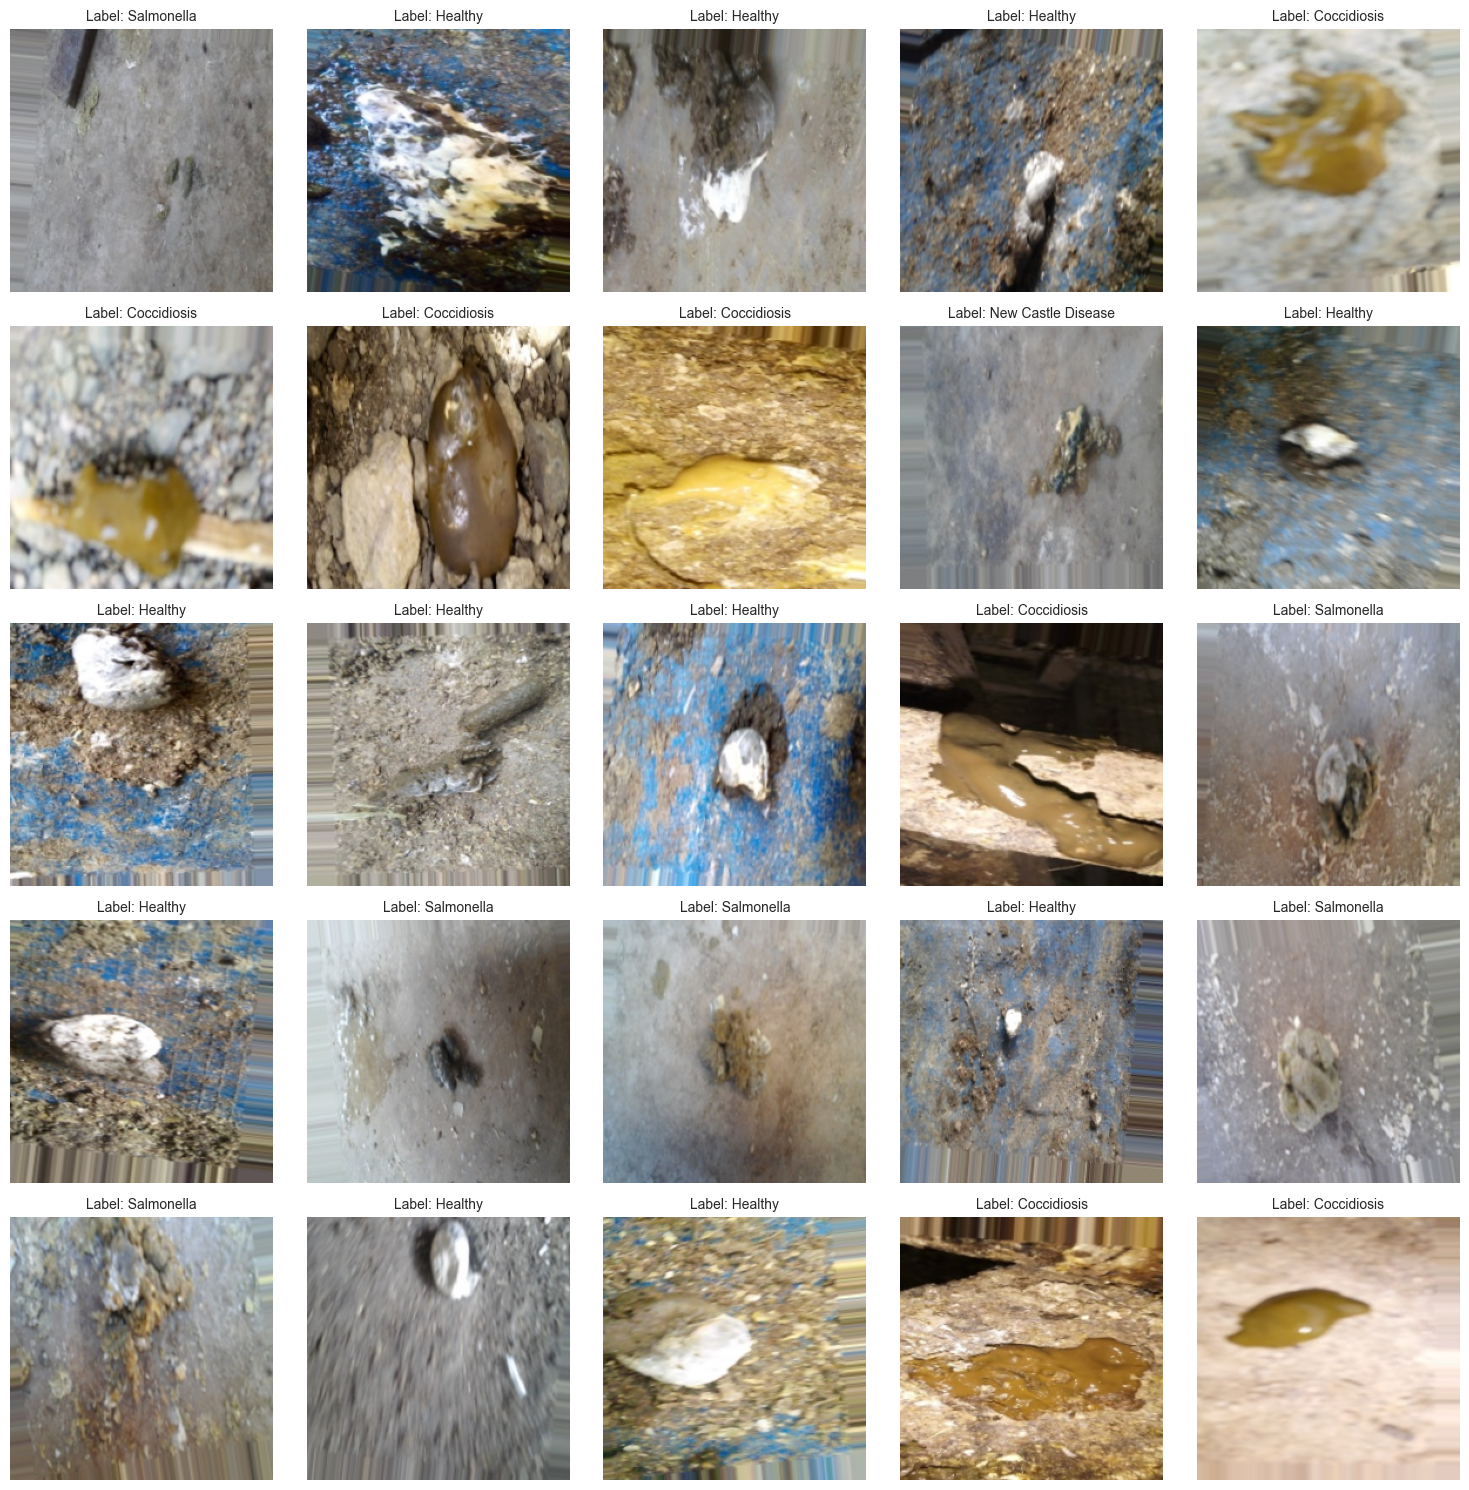

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class names corresponding to the labels
class_names = ['Coccidiosis', 'Salmonella', 'New Castle Disease', 'Healthy']

def show_images(generator, num_images=25):
    '''
    This function fetches a batch of images from the generator and displays them in a 5x5 grid.
    It will show the first `num_images` images from a single batch.
    '''
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Normalize images if necessary (if they are floats and out of range)
    if images.dtype == np.float32 and images.max() > 1.0:
        images = images / 255.0  # Normalize to [0, 1] if needed

    # Set the number of images to display
    num_images = min(num_images, images.shape[0])

    # Set up the plot for displaying images (5x5 grid)
    plt.figure(figsize=(15, 15))

    # Loop through and plot each image
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)  # 5 rows, 5 columns
        plt.imshow(images[i])
        plt.axis('off')

        # Get the label for the image (index of the highest value in one-hot encoding)
        label_index = np.argmax(labels[i])  # Get the index of the class
        label_name = class_names[label_index]  # Map to the class name
        plt.title(f"Label: {label_name}", fontsize=10)

    plt.tight_layout()  # Ensure there's no overlap
    plt.show()

# Call the function to display images from the train_gen
show_images(train_gen)


Membuat model

In [21]:
"""
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in dense layer

# Create pre-trained model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()
"""

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision

# Aktivasi mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Input dan jumlah kelas
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Jumlah kelas

# Load MobileNetV2 sebagai backbone
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)

# Freeze lapisan pretrained untuk transfer learning awal
base_model.trainable = False

# Membangun model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax', dtype='float32')  # Output layer tetap float32
])

# Optimizer dan kompilasi model
model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Fine-tuning setelah beberapa epoch
def unfreeze_model():
    base_model.trainable = True
    print("Unfreezing the base model for fine-tuning.")
    model.compile(
        Adamax(learning_rate=1e-5),  # Learning rate lebih kecil untuk fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,592,068
Trainable params: 331,524
Non-tr

Set Callback Parameters

In [23]:
"""
import numpy as np
from tensorflow.keras.callbacks import Callback

# Define custom callback for learning rate adjustments, early stopping, etc.
class MyCallback(Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.best_accuracy = 0
        self.wait = 0
        self.stop_wait = 0

    def on_epoch_end(self, epoch, logs=None):
        # Adjust learning rate if accuracy does not improve
        current_accuracy = logs.get('accuracy')  # You can also monitor validation accuracy or loss

        if current_accuracy is not None:
            if current_accuracy > self.best_accuracy:
                self.best_accuracy = current_accuracy
                self.wait = 0  # Reset the wait counter
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = float(self.model.optimizer.lr)
                    new_lr = old_lr * self.factor
                    self.model.optimizer.lr = new_lr
                    print(f"Reducing learning rate to {new_lr} due to no improvement in accuracy.")
                    self.wait = 0  # Reset wait after reducing learning rate

        # Stop training early if no improvement after 'stop_patience' epochs
        if self.stop_wait >= self.stop_patience:
            print(f"Stopping training early due to no improvement for {self.stop_patience} epochs.")
            self.model.stop_training = True
        else:
            if current_accuracy < self.threshold:
                self.stop_wait += 1
            else:
                self.stop_wait = 0

        

# Set Callback Parameters
batch_size = 10   # Set batch size for training
epochs = 10       # Number of all epochs in training
patience = 1      # Number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # If train accuracy is < threshold, adjust monitor accuracy; else monitor validation loss
factor = 0.5      # Factor to reduce lr by
ask_epoch = 5     # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size)) # Number of training batches to run per epoch

# Define the callbacks
callbacks = [MyCallback(
    model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
    factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch
)]
"""

import numpy as np
from tensorflow.keras.callbacks import Callback

# Define custom callback for learning rate adjustments, early stopping, etc.
class MyCallback(Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.best_accuracy = 0
        self.wait = 0
        self.stop_wait = 0

    def on_epoch_end(self, epoch, logs=None):
        # Adjust learning rate if accuracy does not improve
        current_accuracy = logs.get('accuracy')  # You can also monitor validation accuracy or loss

        if current_accuracy is not None:
            if current_accuracy > self.best_accuracy:
                self.best_accuracy = current_accuracy
                self.wait = 0  # Reset the wait counter
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = float(self.model.optimizer.lr)
                    new_lr = old_lr * self.factor
                    self.model.optimizer.lr = new_lr
                    print(f"Reducing learning rate to {new_lr} due to no improvement in accuracy.")
                    self.wait = 0  # Reset wait after reducing learning rate

        # Stop training early if no improvement after 'stop_patience' epochs
        if self.stop_wait >= self.stop_patience:
            print(f"Stopping training early due to no improvement for {self.stop_patience} epochs.")
            self.model.stop_training = True
        else:
            if current_accuracy < self.threshold:
                self.stop_wait += 1
            else:
                self.stop_wait = 0


# Set Callback Parameters
batch_size = 32   # Set batch size for training
epochs = 20       # Number of all epochs in training
patience = 2      # Number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 5 # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # If train accuracy is < threshold, adjust monitor accuracy; else monitor validation loss
factor = 0.5      # Factor to reduce lr by
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Define the callbacks
callbacks = [MyCallback(
    model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
    factor=factor, batches=batches, epochs=epochs
)]


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tambahkan checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='model_checkpoint.h5',  # Nama file untuk menyimpan model
    save_best_only=False,  # Set False untuk menyimpan di setiap epoch, bukan hanya model terbaik
    save_weights_only=False,  # Set False untuk menyimpan seluruh model (arsitektur dan bobot)
    verbose=1
)

# Tambahkan ke dalam daftar callbacks
callbacks.append(checkpoint)


Train model

In [25]:
# Train the model
history = model.fit(
    x=train_gen,  # Training data generator
    epochs=epochs,  # Number of epochs
    verbose=1,  # Set verbose to 1 to show training progress
    callbacks=callbacks,  # List of callbacks (e.g., MyCallback for learning rate adjustment and early stopping)
    validation_data=valid_gen,  # Validation data generator
    validation_steps= len(valid_gen),  # You can set validation_steps if needed, or leave it as None
    shuffle=False  # Whether to shuffle the training data or not (set to False for sequential data)
)


Epoch 1/20
202/202 [==============================] - ETA: 0s - loss: 6.1585 - accuracy: 0.8046
Epoch 1: saving model to model_checkpoint.h5
202/202 [==============================] - 93s 428ms/step - loss: 6.1585 - accuracy: 0.8046 - val_loss: 4.5185 - val_accuracy: 0.8823
Epoch 2/20
202/202 [==============================] - ETA: 0s - loss: 3.4976 - accuracy: 0.8692
Epoch 2: saving model to model_checkpoint.h5
202/202 [==============================] - 48s 239ms/step - loss: 3.4976 - accuracy: 0.8692 - val_loss: 2.6839 - val_accuracy: 0.8922
Epoch 3/20
202/202 [==============================] - ETA: 0s - loss: 2.1336 - accuracy: 0.8897
Epoch 3: saving model to model_checkpoint.h5
202/202 [==============================] - 49s 243ms/step - loss: 2.1336 - accuracy: 0.8897 - val_loss: 1.6938 - val_accuracy: 0.8910
Epoch 4/20
202/202 [==============================] - ETA: 0s - loss: 1.4142 - accuracy: 0.8957
Epoch 4: saving model to model_checkpoint.h5
202/202 [=========================

In [26]:
from tensorflow.keras.models import load_model

# Load model dari checkpoint
model = load_model('model_checkpoint.h5')

# Lanjutkan pelatihan
history = model.fit(
    x=train_gen,
    epochs=10,  # Total epoch, dari 1 hingga 10
    initial_epoch=5,  # Mulai dari epoch ke-6 (karena sudah sampai epoch 5)
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    shuffle=False
)


Epoch 6/10
202/202 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.9149Stopping training early due to no improvement for 5 epochs.

Epoch 6: saving model to model_checkpoint.h5
202/202 [==============================] - 52s 248ms/step - loss: 0.6831 - accuracy: 0.9149 - val_loss: 0.6396 - val_accuracy: 0.8984


Display model performance

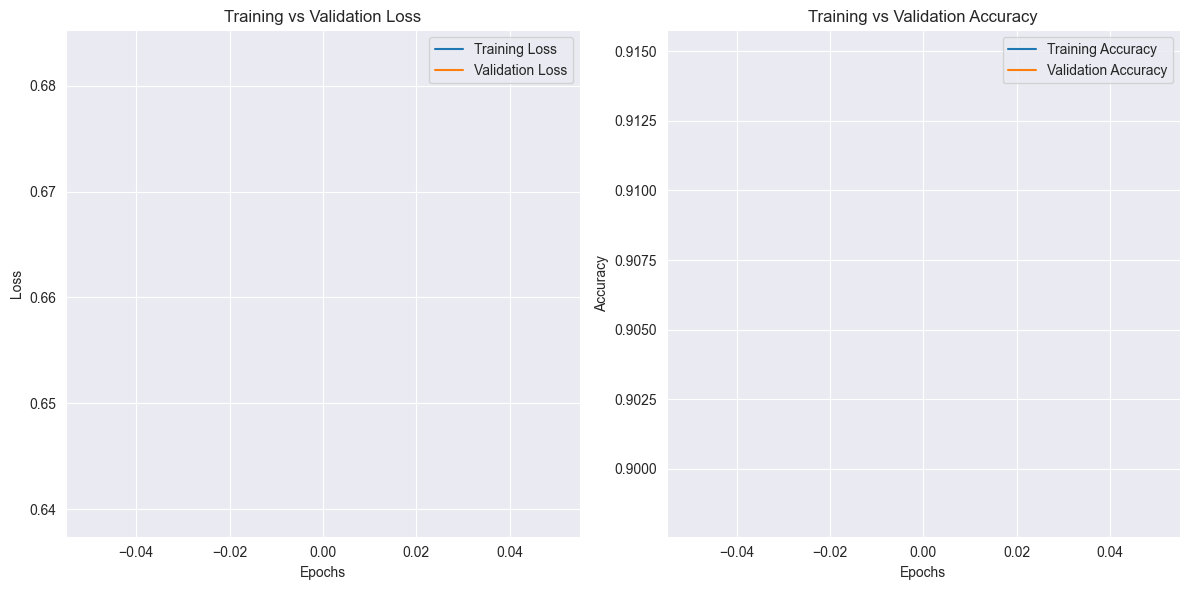

In [27]:
import matplotlib.pyplot as plt

def plot_training(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call plot_training function with your history
plot_training(history)


In [28]:
# Evaluate model performance on validation data
val_loss, val_accuracy = model.evaluate(valid_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


26/26 [==============================] - 2s 34ms/step - loss: 0.6396 - accuracy: 0.8984
Validation Loss: 0.6395944952964783
Validation Accuracy: 0.8983891010284424


Evaluate model

In [29]:
# Menentukan ukuran batch untuk pengujian
ts_length = len(test_gen.filenames)  # Ukuran data untuk pengujian (berdasarkan generator test)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))  # Batch size optimal
test_steps = ts_length // test_batch_size  # Total langkah untuk evaluasi

# Evaluasi model pada data training, validasi, dan pengujian
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Menampilkan hasil evaluasi
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


269/269 [==============================] - 5s 17ms/step - loss: 0.6094 - accuracy: 0.9182
Train Loss:  0.5868756771087646
Train Accuracy:  0.930884838104248
--------------------
Validation Loss:  0.6395730972290039
Validation Accuracy:  0.8983891010284424
--------------------
Test Loss:  0.6094101071357727
Test Accuracy:  0.9182156324386597


Get Predictions

In [30]:
# Gunakan model untuk melakukan prediksi pada data test
preds = model.predict(test_gen, steps=test_steps, verbose=1)

# Ambil argmax dari prediksi untuk mendapatkan kelas yang diprediksi
y_pred = np.argmax(preds, axis=1)

# Tampilkan hasil prediksi
print(y_pred)


269/269 [==============================] - 2s 4ms/step
[1 0 0 1 1 0 1 1 0 3 0 3 0 0 0 0 1 0 3 3 3 3 3 3 0 3 1 3 1 1 0 3 3 1 1 3 3
 0 0 3 3 0 1 0 2 1 3 0 0 1 0 1 0 1 0 0 0 0 1 1 3 3 3 3 1 0 3 1 3 3 0 1 0 2
 0 2 0 3 1 0 3 1 1 0 0 1 0 0 0 1 1 3 1 3 3 3 3 1 3 1 3 3 3 1 3 3 1 1 3 1 1
 0 0 1 3 0 1 1 3 3 3 1 3 1 1 3 0 1 0 3 3 3 0 0 1 1 1 1 0 3 1 1 3 2 3 1 0 1
 3 0 0 1 1 1 0 0 3 3 1 1 2 3 3 0 1 1 2 1 3 0 1 3 0 0 3 3 1 1 1 3 3 3 0 3 1
 3 0 3 0 0 1 1 0 0 3 1 1 1 3 1 1 3 3 0 0 1 3 3 0 0 3 1 3 1 0 3 0 3 1 3 1 1
 3 3 3 0 0 0 3 1 0 1 3 1 1 1 0 0 3 0 3 3 2 0 0 1 1 0 0 1 0 1 0 3 0 3 1 0 1
 3 0 1 3 0 1 0 1 3 1 0 1 3 3 1 0 1 0 0 0 3 3 1 3 0 0 3 0 1 1 0 3 0 1 0 3 3
 1 1 2 1 0 0 3 1 0 1 1 3 1 0 1 0 0 3 0 1 3 3 1 1 3 1 3 1 1 3 1 1 3 2 3 1 1
 3 1 0 0 0 3 3 1 3 1 2 0 1 3 1 1 1 0 0 0 2 2 1 0 2 3 1 3 1 3 3 0 1 0 3 3 1
 1 0 0 1 3 0 3 3 0 1 0 3 3 1 1 3 1 1 0 0 1 3 3 1 3 0 3 1 1 0 1 1 1 3 2 0 3
 0 3 0 3 1 3 3 3 0 0 0 3 0 3 3 1 1 1 3 3 0 1 3 0 3 3 1 1 0 1 1 3 0 3 1 0 3
 1 1 3 2 0 0 1 2 3 3 2 0 1 2 1 1 3 0 1 1 0 3 

### Fine Tuning

In [4]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


NameError: name 'base_model' is not defined

Confusion Matrics and Classification Report

26/26 [==============================] - 2s 40ms/step


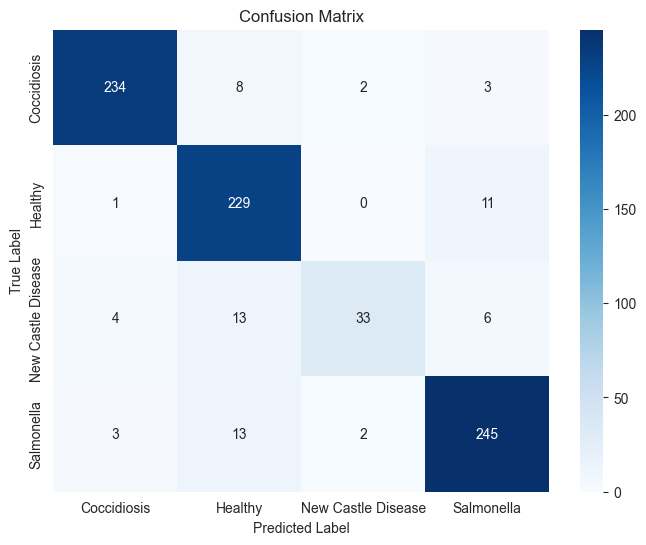

                    precision    recall  f1-score   support

       Coccidiosis       0.97      0.95      0.96       247
           Healthy       0.87      0.95      0.91       241
New Castle Disease       0.89      0.59      0.71        56
        Salmonella       0.92      0.93      0.93       263

          accuracy                           0.92       807
         macro avg       0.91      0.85      0.88       807
      weighted avg       0.92      0.92      0.92       807



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `test_gen` is your test data generator (e.g., ImageDataGenerator)
# `model` is the MobileNetV2 model you've built and trained

# Predict labels for the test set
y_pred = model.predict(test_gen, verbose=1)  # Predict using your MobileNetV2 model

# Convert predictions to class indices (argmax to get the most likely class)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the class labels from the test generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred_classes)

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

# Classification Report
print(classification_report(test_gen.classes, y_pred_classes, target_names=classes))


Predict new image

In [32]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google.colab'

Default Downloads Folder: C:\Users\acal/Downloads
Selected image: C:\Users\acal/Downloads\1.webp


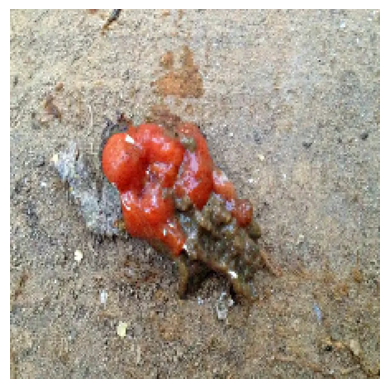

1/1 [==============================] - 1s 590ms/step
Predicted class: Healthy


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('model_checkpoint.h5')  # Path to your saved model

# Path ke folder Downloads
downloads_folder = os.path.expanduser("~/Downloads")  # Mendapatkan path ke folder Downloads
print(f"Default Downloads Folder: {downloads_folder}")

# Nama file gambar di folder Downloads
file_name = "1.webp"  # Ganti dengan nama file gambar yang ada di Downloads
img_path = os.path.join(downloads_folder, file_name)

if os.path.exists(img_path):  # Pastikan file gambar ada
    print(f"Selected image: {img_path}")

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image if needed

    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Make prediction
    predictions = model.predict(img_array)

    # Define the actual class labels based on your dataset
    class_labels = ['Healthy', 'Salmonella', 'New Castle Disease', 'Coccidiosis']

    # Get the predicted class
    predicted_class_index = np.argmax(predictions)  # Get the index of the predicted class
    predicted_class = class_labels[predicted_class_index]  # Get the class name using the predicted index

    # Show the prediction result
    print(f"Predicted class: {predicted_class}")
else:
    print(f"The file {file_name} does not exist in the Downloads folder.")


Save model

In [5]:
import os

# Assuming `model` is your trained MobileNetV2 model
# Assuming `test_score` is a tuple with the loss and accuracy from model evaluation

# Define the save path
save_path = 'F:/model_result'  # Folder path where you want to save the model

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)  # Create the folder if it doesn't exist

# Get model name and accuracy
model_name = model.name  # MobileNetV2 model name
subject = 'Chicken Disease'
#acc = test_score[1] * 100  # Accuracy as percentage

# Save the entire model
save_id = f'{model_name}-{subject}-92per.h5'  # Generate a unique model name based on accuracy
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)  # Save the entire model
print(f'Model was saved as {model_save_loc}')

# Save the model weights
weight_save_id = f'{model_name}-{subject}-weights.h5'  # Generate a unique name for the weights
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)  # Save only the weights
print(f'Weights were saved as {weights_save_loc}')


Model was saved as F:/model_result\sequential-Chicken Disease-92per.h5
Weights were saved as F:/model_result\sequential-Chicken Disease-weights.h5


In [54]:
!ls


 chicken-disease-1.zip		   model_checkpoint.h5			    tai.jpg
'Chicken Disease-class_dict.csv'   sample_data				    train_data.csv
 dataset			  'sequential-Chicken Disease-95.79.h5'
 drive				  'sequential-Chicken Disease-weights.h5'


In [55]:
from google.colab import files

# Unduh file model ke komputer lokal
files.download('sequential-Chicken Disease-95.79.h5')

# Jika Anda ingin mengunduh bobotnya, gunakan:
files.download('sequential-Chicken Disease-weights.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generate CSV files containing classes indicies & image size

In [16]:
import pandas as pd
import os

# Assuming `train_gen` is your ImageDataGenerator instance
# Ensure the save path exists
save_path = 'F:/model_result'  # Folder where you want to save the CSV
os.makedirs(save_path, exist_ok=True)  # Create the folder if it doesn't exist

# Define the subject for naming the CSV
subject = 'Chicken Disease'

# Get the class dictionary from the training data generator
class_dict = train_gen.class_indices

# Image size from MobileNetV2 (Usually 224x224 for MobileNetV2)
img_size = (224, 224, 3)  # Image size MobileNetV2 expects (height, width, channels)
height = []
width = []

# Populate height and width for each class (same for all, as image size is fixed)
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

# Create pandas series for class indices, class labels, height, and width
Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')

# Combine them into a DataFrame
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)

# Save the DataFrame to a CSV file
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'Class CSV file was saved as {csv_save_loc}')


NameError: name 'train_gen' is not defined

In [ ]:
from google.colab import files

# Ganti dengan lokasi penyimpanan yang sesuai
csv_file_path = '/content/Chicken Disease-class_dict.csv'

# Mendownload file
files.download(csv_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>